In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Load MRI file
mri_path = './data/OpenNeuro/ds005073/subjects/sub-S10/anat/sub-S10_rec-1_T1w.nii.gz'
mri_img = nib.load(mri_path)
mri_data = mri_img.get_fdata()

In [7]:
# Print basic information about the MRI data
print("Data shape:", mri_data.shape)
print("Data type:", mri_data.dtype)
print("Affine transformation matrix:\n", mri_img.affine)

Data shape: (192, 300, 320)
Data type: float64
Affine transformation matrix:
 [[-7.97324002e-01  3.46052088e-02  5.54707833e-02  6.14528961e+01]
 [ 1.45496111e-02  7.55645931e-01 -2.62273788e-01 -5.12508926e+01]
 [ 6.37403876e-02  2.60387629e-01  7.53747642e-01 -2.03543610e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [8]:
# Function to display slices
def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
    plt.show()

In [9]:
# Select slices from each axis
slice_0 = mri_data[mri_data.shape[0] // 2, :, :]  # Sagittal slice
slice_1 = mri_data[:, mri_data.shape[1] // 2, :]  # Coronal slice
slice_2 = mri_data[:, :, mri_data.shape[2] // 2]  # Axial slice

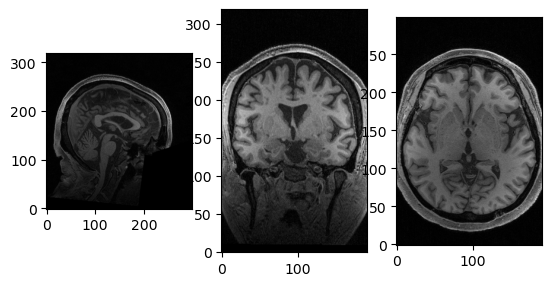

In [10]:
# Display the slices
show_slices([slice_0, slice_1, slice_2])

In [11]:
# Normalize MRI data to [0, 1] range
mri_data_normalized = (mri_data - np.min(mri_data)) / (np.max(mri_data) - np.min(mri_data))

In [12]:
# Load a sample preprocessed scan
sample_scan = np.load('./preprocessing/outputs/ds005073/sub-S49_T1w_normalized.npy')
print("Sample scan shape:", sample_scan.shape)
print("Sample scan min:", np.min(sample_scan), "max:", np.max(sample_scan))

Sample scan shape: (128, 128, 128)
Sample scan min: 0.0 max: 1.0


In [13]:
# Load a sample preprocessed scan
sample_scan = np.load('./preprocessing/outputs/ds005073/sub-S49_T1w_normalized.npy')
print("Sample scan shape:", sample_scan.shape)
print("Sample scan min:", np.min(sample_scan), "max:", np.max(sample_scan))

Sample scan shape: (128, 128, 128)
Sample scan min: 0.0 max: 1.0


In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence

2024-11-05 12:34:59.753968: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 12:35:00.222782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 12:35:00.490078: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 12:35:00.545975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 12:35:00.840435: I tensorflow/core/platform/cpu_feature_guar

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape=(128, 128, 128, 1)):
    model = models.Sequential()
    
    # 1st Convolutional Layer
    model.add(layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    
    # 2nd Convolutional Layer
    model.add(layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    
    # 3rd Convolutional Layer
    model.add(layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

    # 4th Convolutional Layer
    model.add(layers.Conv3D(256, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    
    # Flatten and Fully Connected Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout to prevent overfitting
    
    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification: schizophrenia or control

    return model

# Build the model
input_shape = (128, 128, 128, 1)  # Adjusted input shape
model = build_model(input_shape=input_shape)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)               │ (None, 126, 126, 126,  │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 63, 63, 63, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 61, 61, 61, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 30, 30, 30, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 28, 28, 28,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 14, 14, 14,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 12, 12, 12,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 6, 6, 6, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    14,156,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,318,849 (58.44 MB)

 Trainable params: 15,318,849 (58.44 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
class MRISequence(Sequence):
    def __init__(self, file_paths, labels, batch_size):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
    
    def __len__(self):
        return len(self.file_paths) // self.batch_size
    
    def __getitem__(self, idx):
        batch_files = self.file_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_data = []
        for file in batch_files:
            scan = np.load(file)  # Load the preprocessed .npy file
            scan = np.expand_dims(scan, axis=-1)  # Add channel dimension
            batch_data.append(scan)
        
        return np.array(batch_data), np.array(batch_labels)

In [16]:
# Prepare file paths and labels for train, val, and test
# (Example structure: adjust paths based on your folder structure)
train_files = [f'./data_splits/train/schizophrenia/{f}' for f in os.listdir('./data_splits/train/schizophrenia')] + \
              [f'./data_splits/train/control/{f}' for f in os.listdir('./data_splits/train/control')]
train_labels = [1] * len(os.listdir('./data_splits/train/schizophrenia')) + \
               [0] * len(os.listdir('./data_splits/train/control'))

val_files = [f'./data_splits/val/schizophrenia/{f}' for f in os.listdir('./data_splits/val/schizophrenia')] + \
            [f'./data_splits/val/control/{f}' for f in os.listdir('./data_splits/val/control')]
val_labels = [1] * len(os.listdir('./data_splits/val/schizophrenia')) + \
             [0] * len(os.listdir('./data_splits/val/control'))

test_files = [f'./data_splits/test/schizophrenia/{f}' for f in os.listdir('./data_splits/test/schizophrenia')] + \
             [f'./data_splits/test/control/{f}' for f in os.listdir('./data_splits/test/control')]
test_labels = [1] * len(os.listdir('./data_splits/test/schizophrenia')) + \
              [0] * len(os.listdir('./data_splits/test/control'))

# Set up the data generators
batch_size = 4
train_gen = MRISequence(train_files, train_labels, batch_size=batch_size)
val_gen = MRISequence(val_files, val_labels, batch_size=batch_size)
test_gen = MRISequence(test_files, test_labels, batch_size=batch_size)

In [15]:
epochs = 20  # Start with 20 epochs and adjust based on performance

history = model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 493ms/step - accuracy: 0.2118 - loss: 1.4690 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.6243 - loss: 0.6951 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - accuracy: 0.5410 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - accuracy: 0.6660 - loss: 0.6908 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - accuracy: 0.6660 - loss: 0.6910 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - accuracy: 0.5722 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - accuracy: 0.7424 - loss: 0.6891 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - accuracy: 0.5722 - loss: 0.6913 - val_accuracy: 0.5000 - val_loss:

In [17]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test accuracy: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6667 - loss: 0.6839
Test accuracy: 0.5


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape=(128, 128, 128, 1)):
    model = models.Sequential()
    
    # 1st Convolutional Layer
    model.add(layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    
    # 2nd Convolutional Layer
    model.add(layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    
    # 3rd Convolutional Layer
    model.add(layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

    # Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    
    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

# Build and compile the model with a lower learning rate
model = build_model(input_shape=(128, 128, 128, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/home/raul/miniconda3/envs/MachineLearning/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1730790316.957776  512266 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730790319.218445  512266 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730790319.218632  512266 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730790319.236398

In [18]:
epochs = 20  # Start with 20 epochs and adjust based on performance

history = model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/20


/home/raul/miniconda3/envs/MachineLearning/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-05 12:36:13.662864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-11-05 12:36:21.035415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
I0000 00:00:1730790381.132563  512633 service.cc:146] XLA service 0x7fcfd40125c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730790381.135670  512633 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2024-11-0

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.5100 - loss: 0.8270

E0000 00:00:1730790438.804057  512630 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1730790439.248071  512630 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-11-05 12:37:19.263762: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng13{} for conv (f32[4,32,126,126,126]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[4,1,128,128,128]{4,3,2,1,0}, f32[32,1,3,3,3]{4,3,2,1,0}, f32[32]{0}), window={size=3x3x3}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while

5/5 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - accuracy: 0.5167 - loss: 0.8257 - val_accuracy: 0.5000 - val_loss: 0.7012
Epoch 2/20


2024-11-05 12:37:35.590259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-11-05 12:37:36.385749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 366ms/step - accuracy: 0.4694 - loss: 0.7602 - val_accuracy: 0.5000 - val_loss: 0.6811
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - accuracy: 0.6444 - loss: 0.7091 - val_accuracy: 1.0000 - val_loss: 0.6507
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - accuracy: 0.5375 - loss: 0.7334 - val_accuracy: 0.5000 - val_loss: 0.6858
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step - accuracy: 0.5063 - loss: 0.7367 - val_accuracy: 0.5000 - val_loss: 0.7964
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - accuracy: 0.5410 - loss: 0.7250 - val_accuracy: 0.5000 - val_loss: 0.9527
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - accuracy: 0.6201 - loss: 0.7093 - val_accuracy: 0.5000 - val_loss: 1.1597
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - accuracy: 0.7750 - loss: 0.6439 - val_accuracy: 0.5000 - val_loss: 1.3894
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - accuracy: 0.4111 - loss: 0.7400 - val_accuracy: 0.5000 - val_loss: 1.6505
Ep

In [19]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5000 - loss: 5.1124
Test accuracy: 0.5


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_simplified_model(input_shape=(128, 128, 128, 1)):
    model = models.Sequential()
    
    # 1st Convolutional Layer
    model.add(layers.Conv3D(16, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    
    # 2nd Convolutional Layer
    model.add(layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    
    # 3rd Convolutional Layer
    model.add(layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

    # Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

# Build and compile the simplified model with a lower learning rate
model = build_simplified_model(input_shape=(128, 128, 128, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])


/home/raul/miniconda3/envs/MachineLearning/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
epochs = 20  # Start with 20 epochs and adjust based on performance

history = model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/20


2024-11-05 12:40:31.845838: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=6,k3=0} for conv (f32[16,1,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[4,1,128,128,128]{4,3,2,1,0}, f32[4,16,126,126,126]{4,3,2,1,0}), window={size=3x3x3}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-11-05 12:40:32.664811: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.819136066s
Trying algorithm eng20{k2=6,k3=0} for conv (f32[16,1,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[4,1,128,128,128]{4,3,2,1,0}, f32[4,16,126,126,126]{4,3,2,1,0}), window={size=3x3x3}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"op

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.3467 - loss: 0.7078

E0000 00:00:1730790647.829896  512629 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1730790648.277035  512629 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-11-05 12:40:48.288129: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng13{} for conv (f32[4,16,126,126,126]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[4,1,128,128,128]{4,3,2,1,0}, f32[16,1,3,3,3]{4,3,2,1,0}, f32[16]{0}), window={size=3x3x3}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while

5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3556 - loss: 0.7079 - val_accuracy: 0.5000 - val_loss: 0.6893
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.7424 - loss: 0.6776 - val_accuracy: 0.5000 - val_loss: 0.6895
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - accuracy: 0.6035 - loss: 0.6834 - val_accuracy: 0.5000 - val_loss: 0.6910
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.7215 - loss: 0.6614 - val_accuracy: 0.5000 - val_loss: 0.6914
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.6660 - loss: 0.6616 - val_accuracy: 0.5000 - val_loss: 0.6918
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.5722 - loss: 0.6820 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.5722 - loss: 0.6776 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.4576 - loss: 0.6875 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch

In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test accuracy: {test_accuracy}")